In [54]:
%%capture
# Essas bibliotecas são importantes e precisam estar instaladas.

# SweetViz para auxiliar na análise exploratória
# SKTime para realizar as análises e predições da série temporal

!pip install sweetviz sktime pmdarima sklearn-genetic-opt

In [55]:
# Desativar as mensagens de 'warning' que ficam poluindo o output aqui no Colab

import warnings
warnings.filterwarnings("ignore")

In [56]:
%%capture
# Importações dos módulos necessários para autenticar na minha conta Google e acessar o Drive
import pandas as pd, numpy as np, matplotlib.pyplot as plt, requests as rt

from io import BytesIO

from matplotlib.pylab import rcParams

from pandas.plotting  import register_matplotlib_converters

from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn_genetic import GASearchCV, GAFeatureSelectionCV
from sklearn_genetic.space import Integer, Categorical, Continuous
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn_genetic.callbacks import LogbookSaver, ProgressBar

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional

# Ajustes feitos para geração e criação de gráfico
plt.style.use('ggplot')
rcParams['figure.figsize'] = 15, 6

# Tratar conversões de DateTime entre o Pandas e o Matplotlib
register_matplotlib_converters()

### Formatar Série Temporal para aplicar em modelos de M.L.

Suponha uma série temporal univariada no seguinte formato:<br>
`ts = [1, 2, 3, 4, 5]`

O método `sliding_window` vai separar esta série temporal em <br>
`X_1 | X_2 | ... | X_n || y`

Ou seja, acontecerá a tabulação da série temporal em questão. É possível encontrar sobre este conceito na internet pesquisando por "sliding window" para séries temporais.



In [57]:
def sliding_window(serie, n_steps):
  X, y = list(), list()

  for i in range(len(serie)):
    # Busca o fim do padrão desejado, 'a ponta final' da sequência especificada por 'n_feats'
    end_ix = i + n_steps

    # Verifica se está além do limite desejado
    if end_ix > len(serie) - 1:
      break

    # Pega o input e output segundo o padrão
    seq_x, seq_y = serie[i:end_ix], serie[end_ix]

    # Monta as saídas do método
    X.append(seq_x)
    y.append(seq_y)
  #END-FOR

  return np.array(X), np.array(y)

In [58]:
# Testando o método 'split_ts'
# st = np.array([2216.75, 2713.995, 3098.139, 3213.664, 2848.022, 2785.262, 2464.183, 2485.837, 2314.033, 2000.996, 1559.9, 1402.484, 1547.907, 1735.046, 1799.234, 2162.261, 2749.567, 3306.889, 3725.358, 4294.503, 4434.094, 4077.252, 3433.864, 2608.028, 2103.988])
# print(st.shape)

# X, y = split_ts(st, 3)

# Imprime cada amostra
# for i in range(len(X)):
#   print(X[i], y[i])

# Cria um DataFrame para armazenar os valores de 'X' e outro para os valores de 'y'
# df_X, df_y = pd.DataFrame(data=X, columns=[str('lag_%s' % (i+1)) for i in range(0, 3)]), pd.DataFrame(data=y, columns=['vazao'])

# juntando tudo num único dataframe
# df_full = pd.concat([df_X, df_y], axis=1)

# df_X, df_y, df_full
# df_full

In [59]:
# O corte realizado por esse método é simples: pega do início da série até train_size e coloca num dataframe para treino
# O que resta do corte anterior, é colocado no dataframe para teste
def split_train_test(df, train_size=0.7):

  # Tamanho total da série
  size = df.shape[0]

  # Tamanho do treino
  t_size = int(size * train_size)

  train_data = df.iloc[0:t_size]
  validation_data = df.iloc[t_size:]

  return train_data, validation_data

In [60]:
# treino, validacao = split_train_test(df_full, 0.8)

# treino, validacao

In [61]:
def read_vazoes_medias_serie_completa(codigoEstacao, tipoEstacao, chave):
  link = 'https://docs.google.com/spreadsheets/d/' + chave + '/export?format=xlsx'
  r = rt.get(link)
  data = r.content
  df = pd.read_excel(BytesIO(data), sheet_name='planilha1', header=0, decimal=',', parse_dates=['Data'])

  # Cortando o DataFrame para as colunas de interesse
  df_vazoes = df[['Data', 'NivelConsistencia', 'Media']]

  # Ajustando a coluna correspondente à data para o tipo datetime e convertendo para o formato "Period" de frequência "mensal"
  # A biblioteca 'sktime' só consegue lidar com o campo 'Data' se estiver neste formato de dado
  df_vazoes['Data'] = pd.DatetimeIndex(df_vazoes['Data']).to_period('M')

  # Pegando APENAS os dados consistidos, ou seja, validados pela ANA
  df_vazoes_cons = df_vazoes.loc[df_vazoes['NivelConsistencia'] == 2]
  df_vazoes_cons.set_index('Data', inplace=True)

  # Separa duas Séries: treino e validação para usar com a biblioteca "sktime"
  # Primeiro cria um objeto do tipo pd.Series com a série completa
  serie_vazoes = pd.Series(data=df_vazoes_cons['Media'].values,
                           index=df_vazoes_cons.index,
                           name=str("Vazões médias mensais - estação %s" % codigoEstacao))

  # Pega os últimos 7 anos da série em questão para realizar o estudo
  last7 = pd.Series(serie_vazoes.loc[serie_vazoes.index.year >= 2015], name='last7')

  # A partir do objeto criado anteriormente, agora eu 'corto' entre TREINO e VALIDAÇÃO
  # Será 75% para TESTE e 25% para VALIDAÇÃO calculados à partir do início da série temporal
  treino, validacao = temporal_train_test_split(serie_vazoes, train_size=0.8, anchor="start")
  treino.name, validacao.name = 'Treino', 'Validação'

  # ForecastHorizon, o horizonte de tempo que pretende-se realizar a previsão.
  # Está em questão de meses porque os dados são mensais.
  # A ser utilizado com a biblioteca 'sktime'
  fh = pd.PeriodIndex(data=validacao.index.values)

  ####################################################################################################
  # Neste ponto eu faço ajustes à série temporal para poder empregar em modelos de ML do sckit-learn #
  ####################################################################################################

  # Existe sazonalidade (sz) na série temporal para um período anual, ou seja, de 12 meses
  sz = 12
  X, y = sliding_window(serie_vazoes.values, sz)

  # Depois de criados os arrays, crio o DataFrame que os armazenará
  df_X, df_y = pd.DataFrame(data=X, columns=[str('lag_%s' % (i+1)) for i in range(0, sz)]), pd.DataFrame(data=y, columns=['vazao'])

  # Junto os dois DataFrames criados anteriormente. Isso poderá ser útil em algum momento, já estou deixando aqui pronto
  df_full = pd.concat([df_X, df_y], axis=1)

  train_ml, validation_ml = split_train_test(df_full, 0.8)

  dataset =  {
    'task'              : 'Análise de Série Temporal de Vazões Médias Mensais',
    'name'              : str('Vazões Médias Mensais - estação %s' % codigoEstacao),
    'reference'         : "...",
    'feature_names'     : 'Media',
    'target_names'      : 'Media',
    'n_samples'         : len(serie_vazoes),
    'n_features'        : 1,
    'forecast_horizon'  : fh,
    'y_training'        : treino,
    'y_validation'      : validacao,
    'full_serie'        : serie_vazoes,
    'last7'             : last7,
    'description'       : "Dados de Vazões Médias Mensais consistidos disponibilizados pela Agência Nacional de Águas e Saneamento Básico do Brasil - ANA",
    'X'                 : df_X,
    'y'                 : df_y,
    'full_serie_ml'     : df_full,
    'n_samples_ml'      : df_full.shape[0],
    'n_features_ml'     : df_full.shape[1],
    'feature_names_ml'  : df_X.columns.values,
    'target_names_ml'   : df_y.columns.values,
    'train_ml'          : train_ml,
    'validation_ml'     : validation_ml,
    'raw_data'          : link,
    'station_code'      : codigoEstacao,
    'station_type'      : tipoEstacao,
    }

  return (dataset)

# Realizando a carga dos dados

In [62]:
# Fazendo a carga dos dados a serem analisados
ds = read_vazoes_medias_serie_completa(codigoEstacao='15200000',
                                       tipoEstacao='Fluvial',
                                       chave="1QEsj_zIydw1k0uOgrbSTYX_rJCBU8WG_NcT5xiS_R10")

# ds

In [63]:
# ============================================================================ #
# ================================ IMPORTANTE ================================ #
# =========================== NÃO ESTÁ MAIS EM USO =========================== #
#                                                                              #
# Esta célula está aqui apenas por valor histórico                             #
# Era assim que a carga do arquivo estava sendo feita antes                    #
# ============================================================================ #
# from google.colab         import auth
# from google.auth          import default
# from oauth2client.client  import GoogleCredentials
# ============================================================================ #
# Acessando a planilha e carregando para um DataFrame
# auth.authenticate_user()
# creds, _ = default()
# gc = gspread.authorize(creds)
# spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/google_sheet_id/edit#gid=0')
# spreadsheet = gc.open_by_key('1QEsj_zIydw1k0uOgrbSTYX_rJCBU8WG_NcT5xiS_R10')
# wks = spreadsheet.worksheet('planilha1')
# data = wks.get_all_values()
# headers = data.pop(0)
# df = pandas.DataFrame(data, columns=headers)
# df
# ============================================================================ #
# Cortando o DataFrame para as colunas de interesse
# df_vazoes = df[['Data', 'NivelConsistencia', 'Maxima', 'Minima', 'Media']]
# df_vazoes
# Ajustando os dados das colunas
# Passando o que é numérico para float e data para datetime
# Para converter a string de data para datetime é simples e direto
# df_vazoes['Data'] = pandas.to_datetime(df_vazoes['Data'], format="%m/%Y")
# Converte a string de inteiro para inteiro. Os níveis de consistência são:
# 1 ~> Dado Bruto (não avaliado, não verificado)
# 2 ~> Dado Consistido (dado analisado e confirmado, de acordo)
# df_vazoes['NivelConsistencia'] = pandas.to_numeric(df_vazoes['NivelConsistencia'], errors='coerce')
# Para converter as colunas com strings de números para float demanda um pouco mais de trabalho
# Primeiro tem que fazer um replace na coluna trocando ',' por '.'
# df_vazoes['Maxima'] = df_vazoes['Maxima'].str.replace('.','', regex=True).str.replace(',', '.', regex=True)
# df_vazoes['Media']  = df_vazoes['Media'].str.replace('.','', regex=True).str.replace(',', '.', regex=True)
# df_vazoes['Minima'] = df_vazoes['Minima'].str.replace('.','', regex=True).str.replace(',', '.', regex=True)
# Aí depois chama uma função do Pandas pra jogar tudo pra float
# df_vazoes['Maxima'] = pandas.to_numeric(df_vazoes['Maxima'], errors='coerce')
# df_vazoes['Media']  = pandas.to_numeric(df_vazoes['Media'], errors='coerce')
# df_vazoes['Minima'] = pandas.to_numeric(df_vazoes['Minima'], errors='coerce')
# df_vazoes.dtypes
# df_vazoes
# ============================================================================ #

# Limpeza e ajuste dos dados

In [64]:
# Contando os registros 'not available'/NaN no conjunto de teste
ds['y_training'].isna().sum()

0

In [65]:
# Se a contagem de registros "NaN" for maior que 0, então 'dropa', ou seja, remove as linhas que contenham estes registros
# O parâmetro 'inplace' é pra fazer isso diretamente no conjunto de treino, sem precisar fazer cópia pra outra variável (simplifica o código)
if (ds['y_training'].isna().sum() > 0):
  ds['y_training'].dropna(inplace=True)

In [66]:
# Algumas informações pertinentes sobre os dados que estamos trabalhando.
ds['y_training'].describe()

count     371.000000
mean     2424.739174
std      1907.483432
min       263.157410
25%       580.356200
50%      1820.599900
75%      4046.330100
max      6652.837400
Name: Treino, dtype: float64

# Análise exploratória - série 'y_training' (treino)

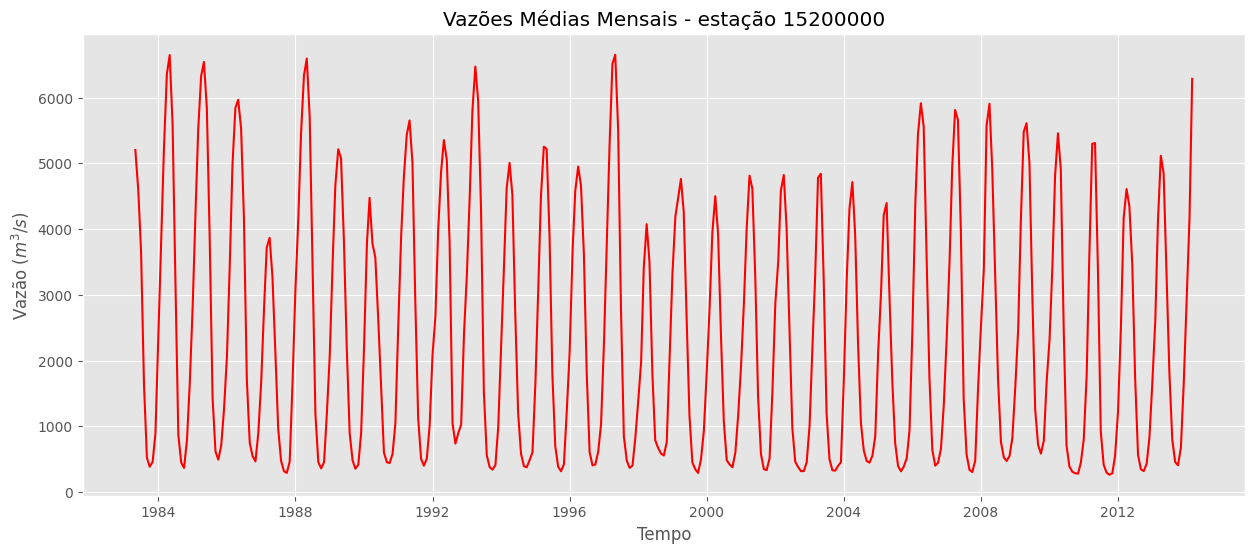

In [67]:
plt.plot(ds['y_training'].index.to_timestamp(), ds['y_training'].values, color='r', linestyle='-')
plt.title(ds['name'])
plt.xlabel('Tempo')
plt.ylabel('Vazão ($m^3/s$)')
plt.grid(True)
plt.show()

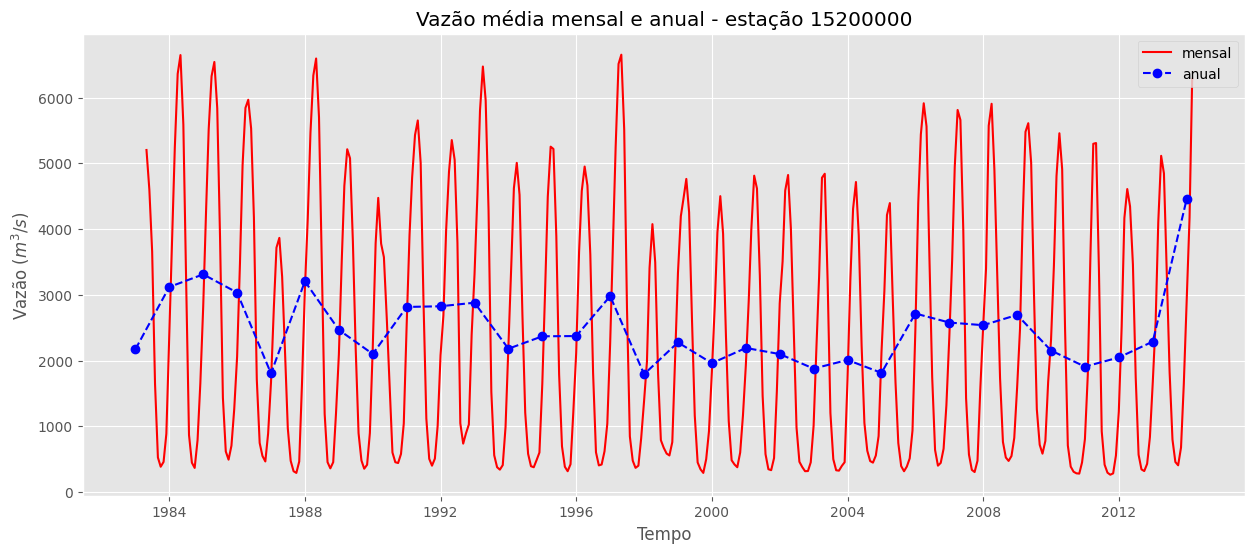

In [68]:
# Colocando ambos os gráficos juntos para facilitar a comparação
plt.plot(ds['y_training'].index.to_timestamp(),
         ds['y_training'].values,
         color='r', label='mensal')

media_anual = ds['y_training'].resample('Y').apply([np.mean])
plt.plot(media_anual.index.to_timestamp(),
         media_anual['mean'],
         color='b', label='anual', marker='o', linestyle='--')

plt.title('Vazão média mensal e anual - estação %s' % ds['station_code'])
plt.xlabel('Tempo')
plt.ylabel('Vazão ($m^3/s$)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

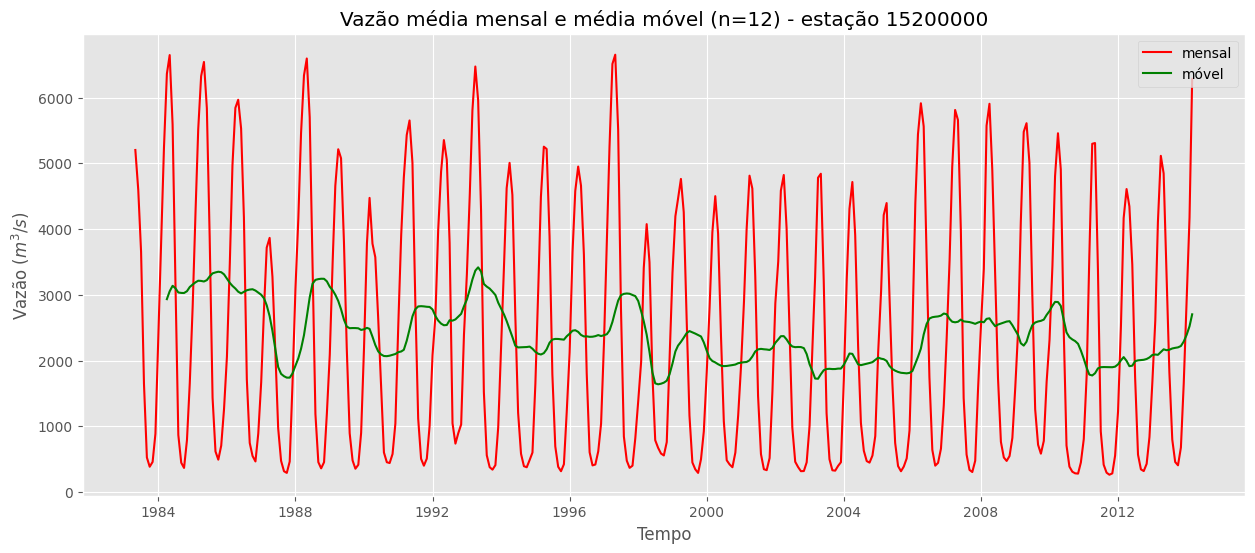

In [69]:
# Aplicando uma média móvel aos dados e, novamente, juntando tudo num único gráfico
# Isso tudo apenas para explorar as informações contidas na série temporal analisada

# Aqui é a série completa de vazões médias mensais
plt.plot(ds['y_training'].index.to_timestamp(),
         ds['y_training'].values,
         color='r', label='mensal', linestyle='-')

# Aqui é a média móvel para um n=12
media_mv = ds['y_training'].rolling(window=12).mean()
plt.plot(media_mv.index.to_timestamp(),
         media_mv.values,
         color='g', label='móvel', linestyle='-')

plt.title('Vazão média mensal e média móvel (n=12) - estação %s' % ds['station_code'])
plt.ylabel('Vazão ($m^3/s$)')
plt.xlabel('Tempo')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [70]:
# Usando o sweetviz para avaliar as vazões médias mensais do período

# import sweetviz as sv
# analyze_report = sv.analyze(ds['train_ml'])
# analyze_report.show_html('analyze.html', open_browser=False)

# Apresentando os resultados
# import IPython
# IPython.display.HTML('analyze.html')

In [71]:
# Criar a Série Temporal a partir do DataFrame criado anteriormente
# serie_vazoes_medias = pd.Series(data=df_vazoes_medias['Media'].values, index=df_vazoes_medias.index, name=str("Vazões médias mensais - estação %s" % "15200000"))

# treino = pd.Series(serie_vazoes_medias.loc[serie_vazoes_medias.index.year < 2021], name='treino')
# teste = pd.Series(serie_vazoes_medias.loc[serie_vazoes_medias.index.year == 2021], name='teste')
# validacao = pd.Series(serie_vazoes_medias.loc[serie_vazoes_medias.index.year > 2021], name='validação')

# treino = pd.Series(data=df_vazoes_medias_cons['Media'].values,
#                    index=df_vazoes_medias_cons.index,
#                    name='Treino')

# validacao = pd.Series(data=df_vazoes_medias_bruto['Media'].values,
#                       index=df_vazoes_medias_bruto.index,
#                       name='Validação')

# treino.shape, teste.shape
# len(serie_vazoes_medias)
# serie_vazoes_medias.name

# Decompondo a Série Temporal

#### Para analisar o comportamento da S.T. de Vazões Médias Mensais ao longo do período


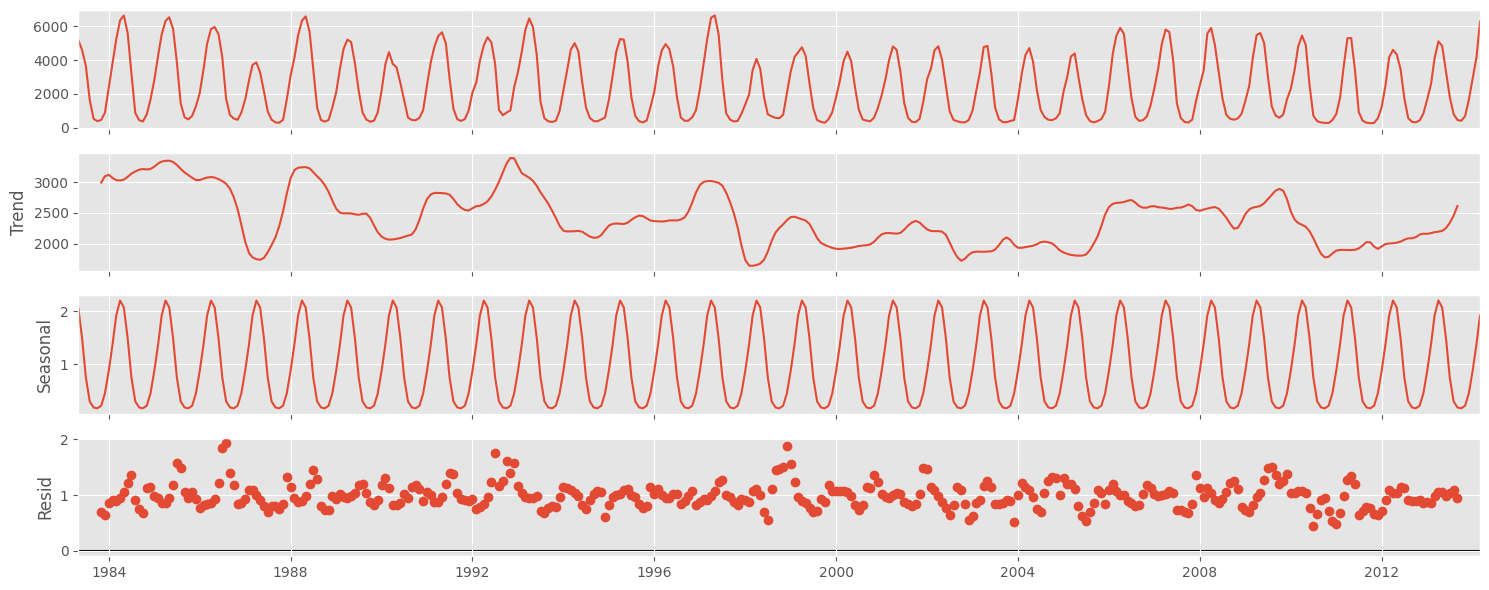

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(pd.Series(data=ds['y_training'].values, index=ds['y_training'].index.to_timestamp()),
                         period=12,
                         model="multiplicative")
res.plot();

In [73]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# res = seasonal_decompose(pd.Series(data=ds['y_train'].values, index=ds['y_train'].index.to_timestamp()),
#                          period=12,
#                          model="additive")
# res.plot();

In [74]:
# Parece que fica claro aqui que a série temporal possui autocorrelação. Acho que é isso. =/
# from pandas.plotting import autocorrelation_plot

# autocorrelation_plot(ds['y_training'])

In [75]:
# Ok, tem essa parada que pode ser usada. Mas,...como interpretar isso? O.o
# from pandas.plotting import lag_plot

# lag_plot(ds['y_training'])

 # Teste de Estacionariedade

In [76]:
from statsmodels.tsa.stattools import adfuller

In [77]:
X = ds['y_training'].values
result = adfuller(X)
print('Estatística ADF: %f' % result[0])
print('p-value: %f' % result[1])

print('Valores Críticos:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

Estatística ADF: -4.390457
p-value: 0.000309
Valores Críticos:
	1%: -3.449
	5%: -2.870
	10%: -2.571


Analisando o '**p-value**', menor que 0,05 indica que a `série é estacionária`.

In [78]:
# ds_diff_1 = ds['y_train'].diff().dropna()
# ds_diff_2 = ds_diff_1.diff().dropna()

# print('Test stationarity for original series')
# print('-------------------------------------')
# adfuller_result = adfuller(ds['y_train'].values)
# print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

# print('\nTest stationarity for differenced series (order=1)')
# print('--------------------------------------------------')
# adfuller_result = adfuller(ds_diff_1)
# print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

# print('\nTest stationarity for differenced series (order=2)')
# print('--------------------------------------------------')
# adfuller_result = adfuller(ds_diff_2)
# print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

In [79]:
# fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 6), sharex=True)
# ds['y_train'].plot(ax=axs[0], title='Original time series')
# ds_diff_1.plot(ax=axs[1], title='Differenced order 1')
# ds_diff_2.plot(ax=axs[2], title='Differenced order 2');

# Gráficos ACF e PACF para tentar detectar os parâmetros "p" e "q" para o SARIMA

In [80]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Text(0.5, 1.0, 'Autocorrelação em "y_training"')

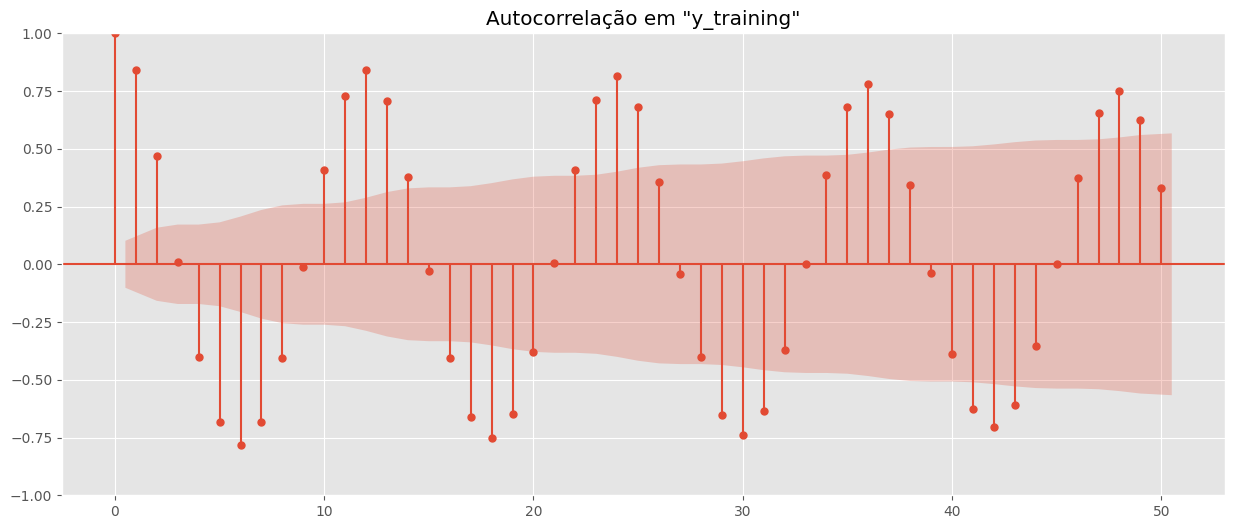

In [81]:
# Autocorrelation plot for original and differenced series
# ==============================================================================
# fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 6), sharex=True)
fig, axs = plt.subplots(figsize=(15, 6), sharex=True)
plot_acf(ds['y_training'], ax=axs, lags=50, alpha=0.05)
axs.set_title('Autocorrelação em "y_training"')
# plot_acf(ds_diff_1, ax=axs[1], lags=50, alpha=0.05)
# axs[1].set_title('Autocorrelation differenced series (order=1)');
# plot_acf(ds_diff_2, ax=axs[2], lags=50, alpha=0.05)
# axs[2].set_title('Autocorrelation differenced series (order=2)');

Text(0.5, 1.0, 'Autocorrelação parcial em "y_training"')

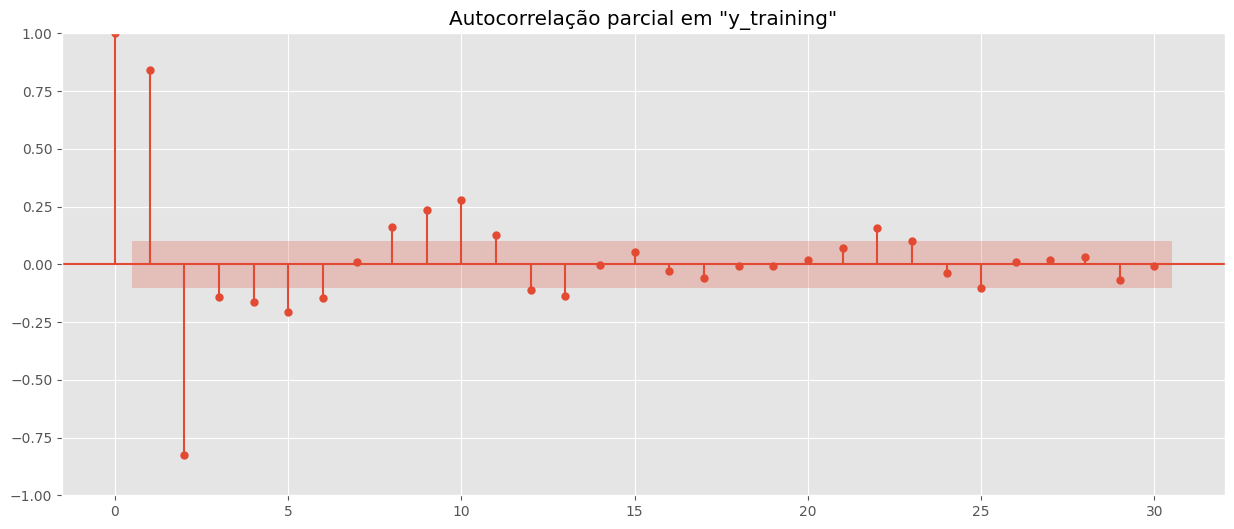

In [82]:
# Partial autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(figsize=(15, 6), sharex=True)
plot_pacf(ds['y_training'], ax=axs, lags=30, alpha=0.05)
axs.set_title('Autocorrelação parcial em "y_training"')
# plot_pacf(ds_diff_1, ax=axs[1], lags=30, alpha=0.05)
# axs[1].set_title('Partial autocorrelation differenced series (order=1)');
# plot_pacf(ds_diff_2, ax=axs[2], lags=29, alpha=0.05)
# axs[2].set_title('Partial autocorrelation differenced series (order=2)');

In [83]:
# # First order differentiation combined with seasonal differentiation
# # ==============================================================================
# ds_diff_1_12 = ds['y_train'].diff(1).diff(12).dropna()

# warnings.filterwarnings("ignore")
# adfuller_result = adfuller(ds_diff_1_12)
# print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

# Aplicação da biblioteca sktime

#### Esta biblioteca já possui alguns modelos de previsão implementados

In [84]:
from sktime.utils import seasonality

# Esta verificação confirma que a série usada no treino tem autocorrelação e é mesmo sazonal para n=12 (meses)
seasonality.autocorrelation_seasonality_test(ds['y_training'], sp=12) # -> True

True

In [85]:
# Utiliza SMAPE para calcular o desempenho de cada método
smape = MeanAbsolutePercentageError(symmetric=True)

# Variável para armazenar todos os cálculos de desempenho dos métodos empregados
desempenho = {}

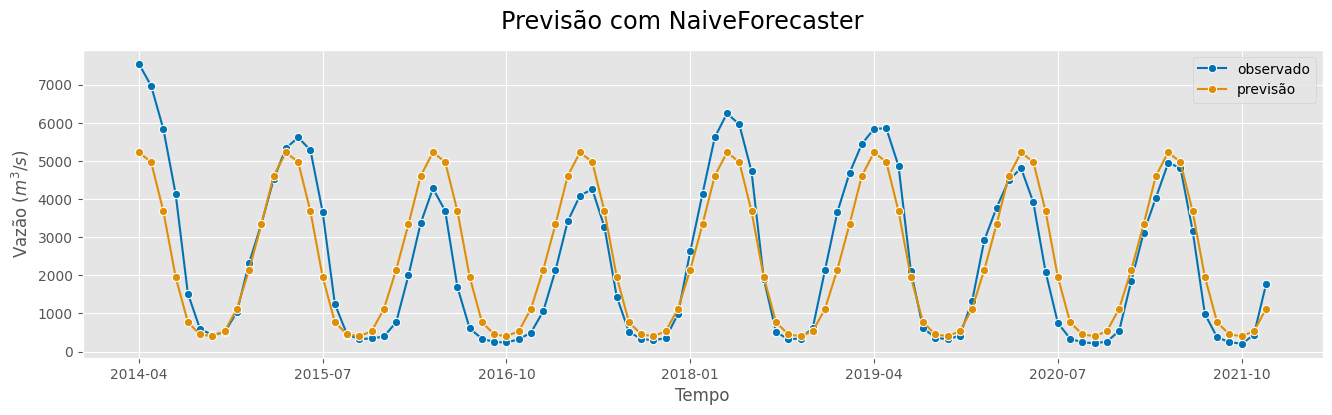

In [86]:
from sktime.forecasting.naive import NaiveForecaster

naive_fc = NaiveForecaster(strategy='mean', sp=12)  # 'sp' é o tamanho da sazonalidade. No caso desta S.T. é 12, ou seja, 12 meses (1 ano)
naive_fc.fit(ds['y_training'])
naive_previsao = naive_fc.predict(fh=ds['forecast_horizon'])

plot_series(ds['y_validation'], naive_previsao,
            labels=["observado", "previsão"],
            x_label='Tempo',
            y_label='Vazão ($m^3/s$)',
            title='Previsão com NaiveForecaster')#,
            # pred_interval=naive_fc.predict_interval(fh=ds['forecast_horizon'], coverage=0.5))

desempenho['NaiveForecaster'] = {'sMAPE': smape(ds['y_validation'].values, naive_previsao.values),
                                 'R2': r2_score(ds['y_validation'].values, naive_previsao.values)}

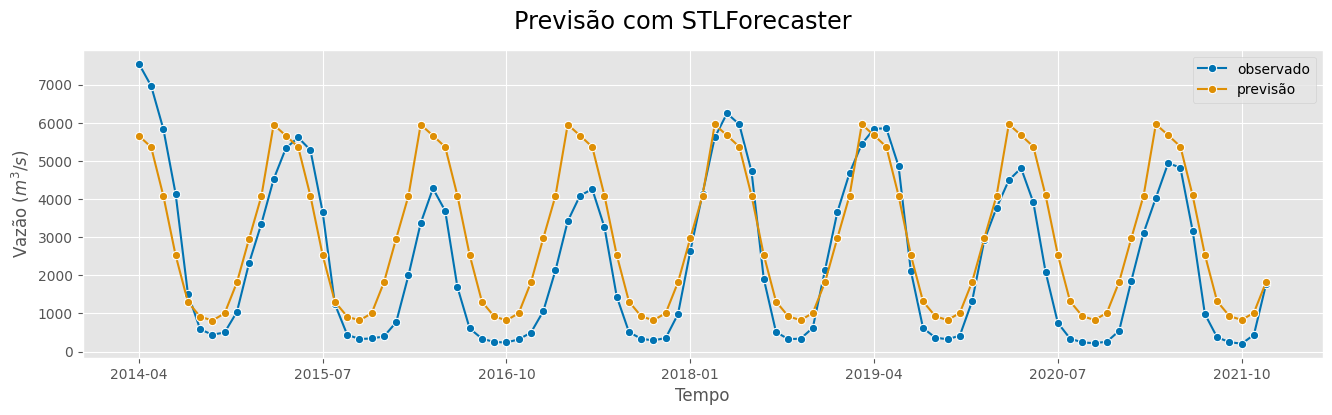

In [87]:
from sktime.forecasting.trend import STLForecaster

stl_fc = STLForecaster(sp=12, seasonal=5)
stl_fc.fit(ds['y_training'])
stl_previsao = stl_fc.predict(fh=ds['forecast_horizon'])

plot_series(ds['y_validation'], stl_previsao,
            labels=["observado", "previsão"],
            x_label='Tempo',
            y_label='Vazão ($m^3/s$)',
            title='Previsão com STLForecaster')

desempenho['STLForecaster'] = {'sMAPE': smape(ds['y_validation'].values, stl_previsao.values),
                               'R2': r2_score(ds['y_validation'].values, stl_previsao.values)}

In [88]:
from pmdarima import auto_arima

# Avaliando o que o AutoARIMA me dá como melhores parâmetros
# auto_arima(ds['y_training'], seasonal=True, m=12, max_p=5, max_d=2, max_q=5, max_P=5, max_D=3, max_Q=5).summary()

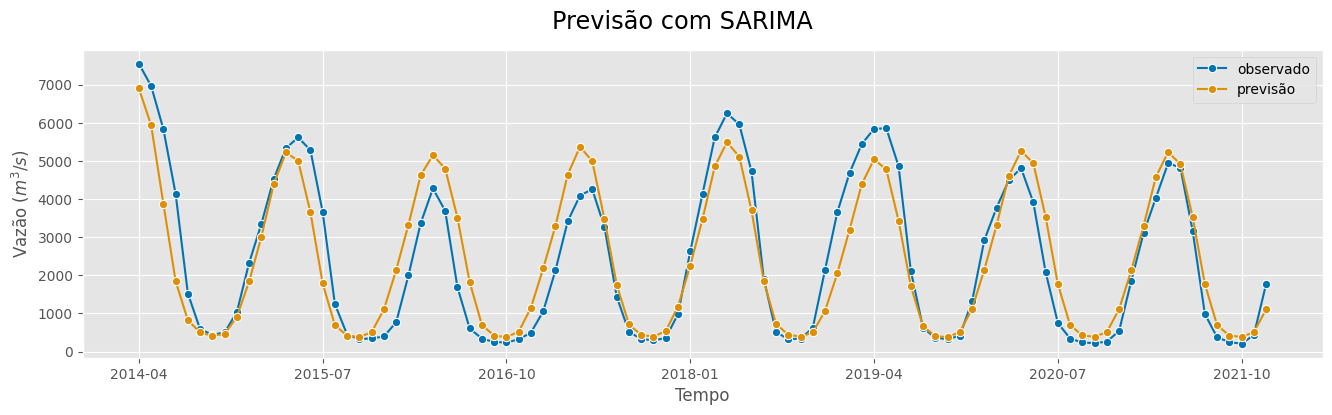

In [89]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

m_sarima = SARIMAX(ds['y_training'], order = (2, 0, 2), seasonal_order = (3, 0, 5, 12), initialization='approximate_diffuse')
m_sarima_result = m_sarima.fit()

sarima_previsao = m_sarima_result.predict(start = len(ds['y_training']), end = len(ds['full_serie']) - 1, typ="levels").rename("SARIMA prev")
plot_series(ds['y_validation'], sarima_previsao,
            labels=["observado", "previsão"],
            x_label='Tempo',
            y_label='Vazão ($m^3/s$)',
            title='Previsão com SARIMA')


desempenho['SARIMA'] = {'sMAPE': smape(ds['y_validation'].values, sarima_previsao.values),
                        'R2': r2_score(ds['y_validation'].values, sarima_previsao.values)}

# m_sarima_result.summary()

# Aplicação da biblioteca sklearn

A partir deste ponto é aplicação apenas da biblioteca sklearn e os modelos aprendidos em sala de aula

### Preparação dos dados de treinamento e validação.

In [90]:
# Estes valores de "X" e "y" serão aplicados igualmente aos modelos a seguir, sejam eles lineares ou não-lineares.
# Não há distinção no formato de entrada dos dados para eles.

_X = ds['train_ml'][['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12']]
_y = ds['train_ml'][['vazao']]

# O mesmo serve para os dados de validação
_X_pred = ds['validation_ml'][['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12']]

# Forecasting com LinearRegression

Modelo `m_lr`

In [91]:
m_lr = LinearRegression()
m_lr.fit(_X, _y)

LinearRegression()

In [92]:
pred_lr = m_lr.predict(_X_pred)
vazao_pred_lr = pd.DataFrame(data=pred_lr, columns=['pred'])
vazao_pred_lr['observed'] = ds['validation_ml'].vazao.values

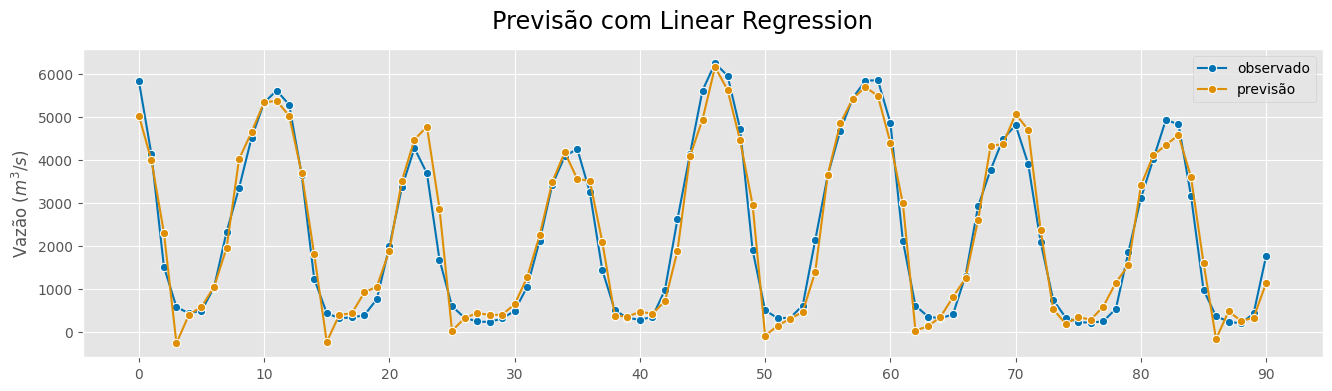

In [93]:
plot_series(vazao_pred_lr['observed'], vazao_pred_lr['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Previsão com Linear Regression')


desempenho['LinearRegression'] = {'sMAPE': smape(vazao_pred_lr['observed'].values, vazao_pred_lr['pred'].values),
                                  'R2': r2_score(vazao_pred_lr['observed'].values, vazao_pred_lr['pred'].values)}

# Forecasting com GBoosting

In [94]:
m_gb = GradientBoostingRegressor()
m_gb.fit(_X, _y)

GradientBoostingRegressor()

In [95]:
pred_gb = m_gb.predict(_X_pred)
vazao_pred_gb = pd.DataFrame(data=pred_gb, columns=['pred'])
vazao_pred_gb['observed'] = ds['validation_ml'].vazao.values

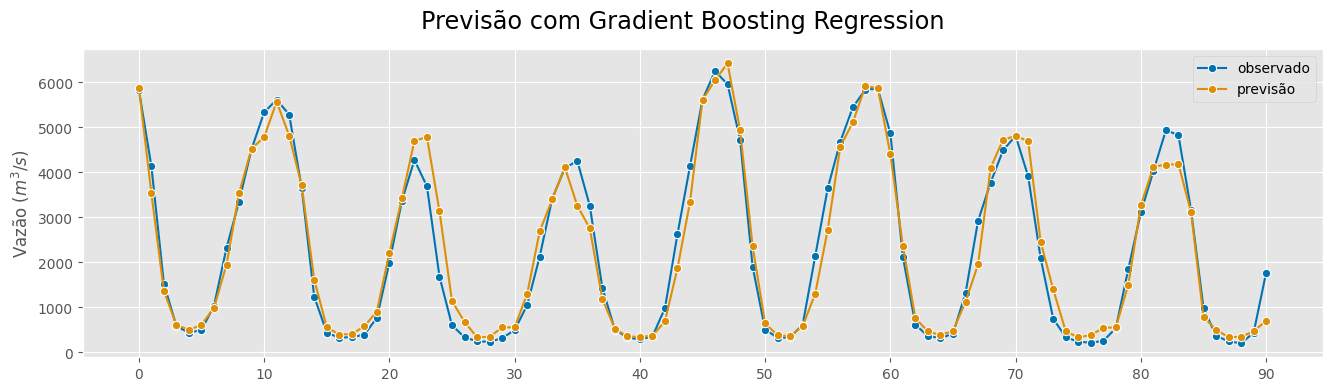

In [96]:
plot_series(vazao_pred_gb['observed'], vazao_pred_gb['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Previsão com Gradient Boosting Regression')


desempenho['GradientBoostingRegressor'] = {'sMAPE': smape(vazao_pred_gb['observed'].values, vazao_pred_gb['pred'].values),
                                           'R2': r2_score(vazao_pred_gb['observed'].values, vazao_pred_gb['pred'].values)}

# Forecasting com kNN (vizinhos mais próximos)

Essa técnica é interessante porque dá mais peso às observações mais próximas. Como a série tem sazonalidade, medições mais próximas tendem a influeciar mais.

In [97]:
m_knn = KNeighborsRegressor(n_neighbors=12, weights='distance')
m_knn.fit(_X, _y)

KNeighborsRegressor(n_neighbors=12, weights='distance')

In [98]:
pred_knn = m_knn.predict(_X_pred)
vazao_pred_knn = pd.DataFrame(data=pred_knn, columns=['pred'])
vazao_pred_knn['observed'] = ds['validation_ml'].vazao.values

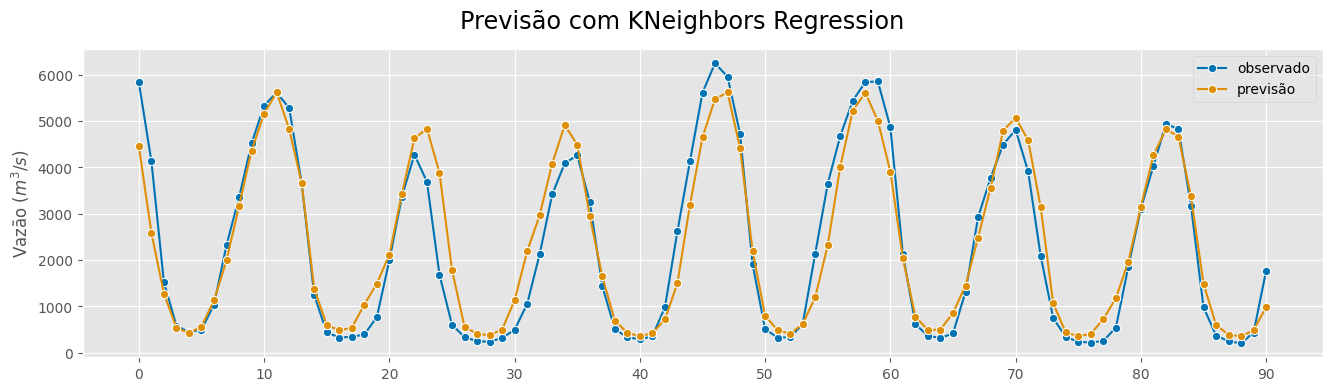

In [99]:
plot_series(vazao_pred_knn['observed'], vazao_pred_knn['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Previsão com KNeighbors Regression')

desempenho['KNeighborsRegressor'] = {'sMAPE': smape(vazao_pred_knn['observed'].values, vazao_pred_knn['pred'].values),
                                     'R2': r2_score(vazao_pred_knn['observed'].values, vazao_pred_knn['pred'].values)}

# Forecasting com RandomForest

In [100]:
m_rf = RandomForestRegressor()
m_rf.fit(_X, _y)

RandomForestRegressor()

In [101]:
pred_rf = m_rf.predict(_X_pred)
vazao_pred_rf = pd.DataFrame(data=pred_rf, columns=['pred'])
vazao_pred_rf['observed'] = ds['validation_ml'].vazao.values

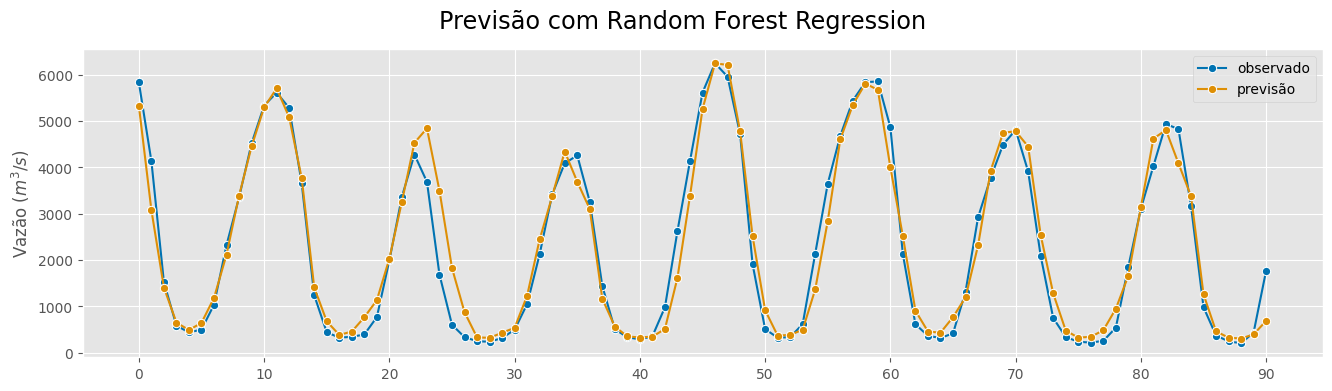

In [102]:
plot_series(vazao_pred_rf['observed'], vazao_pred_rf['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Previsão com Random Forest Regression')

desempenho['RandomForestRegressor'] = {'sMAPE': smape(vazao_pred_rf['observed'].values, vazao_pred_rf['pred'].values),
                                       'R2': r2_score(vazao_pred_rf['observed'].values, vazao_pred_rf['pred'].values)}

# Forecasting com Deep Learning

Agora farei forecasting usando redes LSTM.

### Preparando os dados

Para colocar os dados no formato que a rede LSTM aceita. É um procedimento enjoado de aprender no início, fácil de errar.

Seguindo essa forma que trabalhei, no entanto, fica bem tranquilo de estender.

In [103]:
X_lstm = ds['train_ml'][['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12']]
X_lstm = X_lstm.values.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)
X_lstm.shape

(361, 12, 1)

In [104]:
# Preciso criar agora uma coluna de alvo que fará parte do treinamento da rede.
# A coluna "y" correspondente ao "X" de antes. Neste caso eu preciso da coluna "vazao"

y_lstm = ds['train_ml'][['vazao']]
y_lstm = y_lstm.values.reshape(y_lstm.shape[0], y_lstm.shape[1], 1)
y_lstm.shape

(361, 1, 1)

In [105]:
# Dados a partir dos quais o modelo deverá prever as vazões.

X_pred_lstm = ds['validation_ml'][['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12']]
X_pred_lstm = X_pred_lstm.values.reshape(X_pred_lstm.shape[0], X_pred_lstm.shape[1], 1)
X_pred_lstm.shape

(91, 12, 1)

### Vanilla LSTM

Este é um modelo básico de LSTM.

`m_lstm`

In [106]:
m_lstm = Sequential()
m_lstm.add(LSTM(128, activation='relu', input_shape=(X_lstm.shape[1], 1)))
m_lstm.add(Dense(1))
m_lstm.compile(optimizer='adam', loss='mse')

In [107]:
m_lstm.fit(X_lstm, y_lstm, epochs=250, verbose=0)

Epoch 1/250
12/12 [==============================] - 2s 17ms/step - loss: 8961439.0000
Epoch 2/250
12/12 [==============================] - 0s 18ms/step - loss: 7621228.0000
Epoch 3/250
12/12 [==============================] - 0s 18ms/step - loss: 5127721.5000
Epoch 4/250
12/12 [==============================] - 0s 17ms/step - loss: 3133662.2500
Epoch 5/250
12/12 [==============================] - 0s 18ms/step - loss: 1892550.3750
Epoch 6/250
12/12 [==============================] - 0s 18ms/step - loss: 1465789.7500
Epoch 7/250
12/12 [==============================] - 0s 17ms/step - loss: 1293571.2500
Epoch 8/250
12/12 [==============================] - 0s 18ms/step - loss: 1138277.7500
Epoch 9/250
12/12 [==============================] - 0s 17ms/step - loss: 1144951.5000
Epoch 10/250
12/12 [==============================] - 0s 17ms/step - loss: 1032390.3750
Epoch 11/250
12/12 [==============================] - 0s 18ms/step - loss: 846896.3125
Epoch 12/250
12/12 [======================

In [ ]:
vazao_pred = m_lstm.predict(X_pred_lstm, verbose=0)

vazao_pred_df = pd.DataFrame(data=vazao_pred, columns=['pred'])
vazao_pred_df['observed'] = ds['validation_ml'].vazao.values

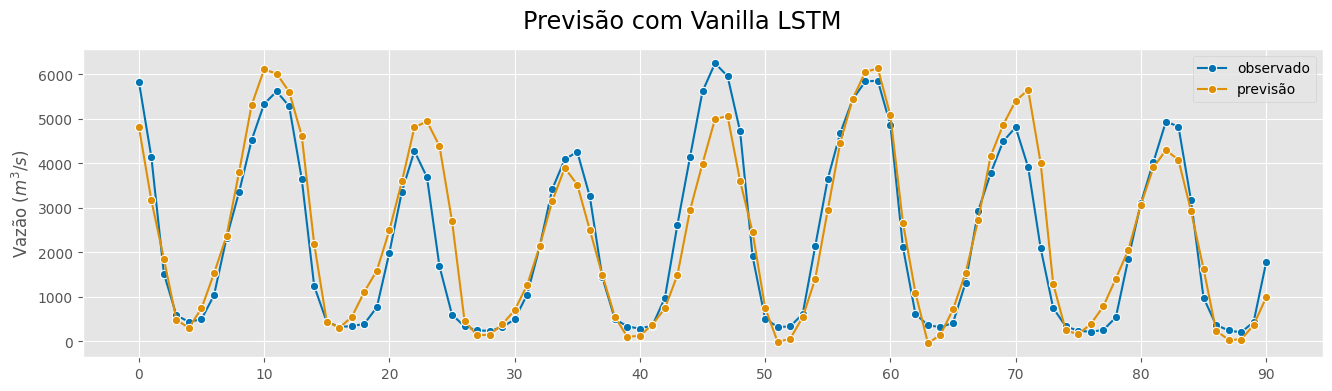

In [ ]:
plot_series(vazao_pred_df['observed'], vazao_pred_df['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Previsão com Vanilla LSTM')

desempenho['VanillaLSTM'] = {'sMAPE': smape(vazao_pred_df['observed'].values, vazao_pred_df['pred'].values),
                             'R2': r2_score(vazao_pred_df['observed'].values, vazao_pred_df['pred'].values)}

### Bidirectional LSTM

A característica deste modelo é que ele guarda e passa informações para a célula adiante e retorna para células atrás informações que foram ajustadas à frente, na rede. Isso potencializa o aprendizado do modelo.

`m_bi_lstm`

In [ ]:
m_bi_lstm = Sequential()
m_bi_lstm.add(Bidirectional(LSTM(128, activation='relu', input_shape=(X_lstm.shape[1], 1))))
m_bi_lstm.add(Dense(1))
m_bi_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
%%capture
m_bi_lstm.fit(X_lstm, y_lstm, epochs=250, verbose=0)

In [ ]:
vazao_pred = m_bi_lstm.predict(X_pred_lstm, verbose=0)

vazao_pred_df = pd.DataFrame(data=vazao_pred, columns=['pred'])
vazao_pred_df['observed'] = ds['validation_ml'].vazao.values

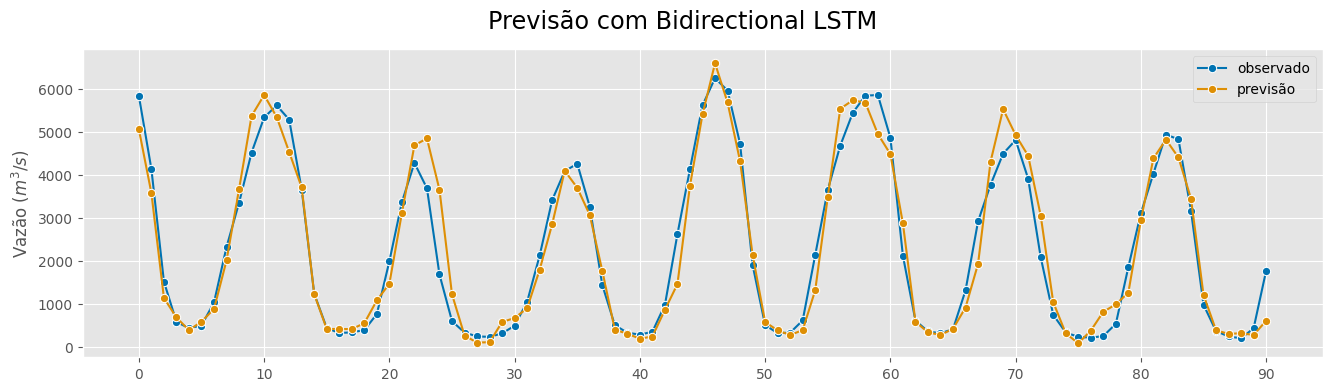

In [ ]:
plot_series(vazao_pred_df['observed'], vazao_pred_df['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Previsão com Bidirectional LSTM')

desempenho['BidirectionalLSTM'] = {'sMAPE': smape(vazao_pred_df['observed'].values, vazao_pred_df['pred'].values),
                                   'R2': r2_score(vazao_pred_df['observed'].values, vazao_pred_df['pred'].values)}

### Stacked LSTM

A ideia aqui é criar um modelo com mais de uma camada oculta, visando o aprimoramento dos resultados.

`m_stk_lstm`

In [ ]:
m_stk_lstm = Sequential()
m_stk_lstm.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_lstm.shape[1], 1)))
m_stk_lstm.add(LSTM(128, activation='relu'))
m_stk_lstm.add(Dense(1))
m_stk_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
%%capture
m_stk_lstm.fit(X_lstm, y_lstm, epochs=250, verbose=0)

In [ ]:
vazao_pred = m_stk_lstm.predict(X_pred_lstm, verbose=0)

vazao_pred_df = pd.DataFrame(data=vazao_pred, columns=['pred'])
vazao_pred_df['observed'] = ds['validation_ml'].vazao.values

In [ ]:
plot_series(vazao_pred_df['observed'], vazao_pred_df['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Previsão com Stacked LSTM')

desempenho['StackedLSTM'] = {'sMAPE': smape(vazao_pred_df['observed'].values, vazao_pred_df['pred'].values),
                             'R2': r2_score(vazao_pred_df['observed'].values, vazao_pred_df['pred'].values)}

### Stacked Bidirectional LSTM

In [ ]:
m_stk_bi_lstm = Sequential()
m_stk_bi_lstm.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_lstm.shape[1], 1))))
m_stk_bi_lstm.add(Bidirectional(LSTM(128, activation='relu')))
m_stk_bi_lstm.add(Dense(1))
m_stk_bi_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
%%capture
m_stk_bi_lstm.fit(X_lstm, y_lstm, epochs=250, verbose=0)

In [ ]:
vazao_pred = m_stk_bi_lstm.predict(X_pred_lstm, verbose=0)

vazao_pred_df = pd.DataFrame(data=vazao_pred, columns=['pred'])
vazao_pred_df['observed'] = ds['validation_ml'].vazao.values

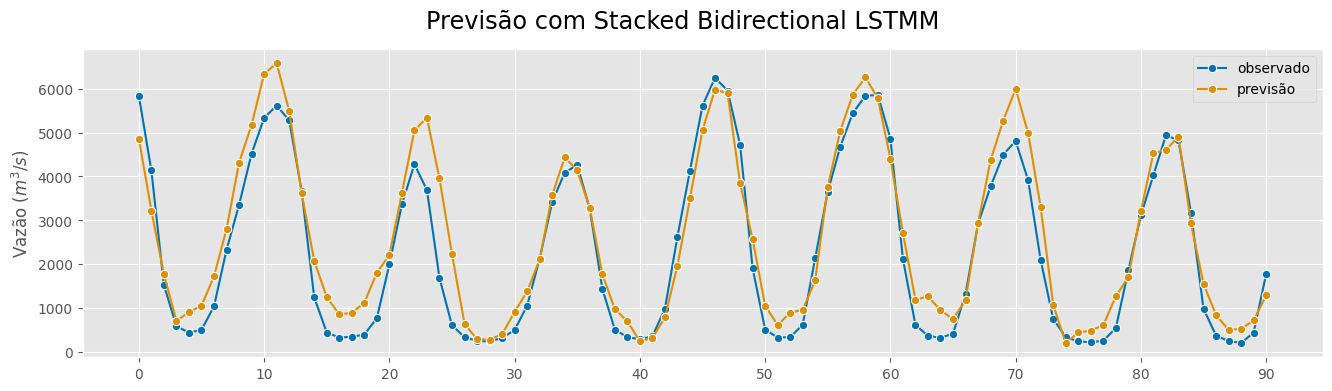

In [ ]:
plot_series(vazao_pred_df['observed'], vazao_pred_df['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Previsão com Stacked Bidirectional LSTMM')

desempenho['StackedBidirectionalLSTM'] = {'sMAPE': smape(vazao_pred_df['observed'].values, vazao_pred_df['pred'].values),
                                          'R2': r2_score(vazao_pred_df['observed'].values, vazao_pred_df['pred'].values)}

In [ ]:
# Faz o print da qualidade dos resultados de cada método empregado

for _m1 in desempenho.items():
  print(_m1[0] + "\n\t" + "sMAPE:\t" + str(_m1[1]['sMAPE'])
               + "\n\t" + "R2:\t"    + str(_m1[1]['R2']))

NaiveForecaster
	sMAPE:	0.3475658500844448
	R2:	0.822013317311716
STLForecaster
	sMAPE:	0.5534640142915928
	R2:	0.710756439409158
SARIMA
	sMAPE:	0.32972417530027215
	R2:	0.8455660838659746
LinearRegression
	sMAPE:	0.33858614222031186
	R2:	0.9509544903858448
GradientBoostingRegressor
	sMAPE:	0.19543321579228703
	R2:	0.954566485509729
KNeighborsRegressor
	sMAPE:	0.27471146778881106
	R2:	0.9107619436749537
RandomForestRegressor
	sMAPE:	0.22489987354327493
	R2:	0.9482624027855494
VanillaLSTM
	sMAPE:	0.2574752592224539
	R2:	0.9024068090153079
BidirectionalLSTM
	sMAPE:	0.25615038676368246
	R2:	0.9346979918813282
StackedLSTM
	sMAPE:	0.3394327779325182
	R2:	0.8527130595707181
StackedBidirectionalLSTM
	sMAPE:	0.3586257948900816
	R2:	0.8955634282883632


# Otimização de hiperparâmetros

Aplicar a lib `sklearn-genetic-opt` para encontrar os melhores parâmetros para alguns modelos.

In [ ]:
# Cross-Validation específico para Séries Temporais
cv = TimeSeriesSplit(n_splits=8)

In [ ]:
# from sklearn.metrics import get_scorer_names
# get_scorer_names()

## GBoosting optimization

In [ ]:
# param_grid = {
#     "n_estimators": Integer(10, 500),
#     "loss": Categorical(["absolute_error", "squared_error"]),
#     "max_depth": Integer(2, 15),
#     "learning_rate": Continuous(0.001, 0.01, distribution="log-uniform")}

In [ ]:
# evolved_estimator = GASearchCV(estimator=m_gb,
#                                cv=cv,
#                                scoring="r2",
#                                population_size=20,
#                                generations=10,
#                                elitism=True,
#                                keep_top_k=3,
#                                crossover_probability=0.9,
#                                mutation_probability=0.1,
#                                param_grid=param_grid,
#                                criteria="max",
#                                algorithm="eaMuPlusLambda",
#                                n_jobs=-1)

In [ ]:
# evolved_estimator.fit(_X, _y)
# y_predict_ga = evolved_estimator.predict(_X_pred)
# r2 = r2_score(vazao_pred_gb['observed'].values, y_predict_ga)

In [ ]:
# print(evolved_estimator.best_params_)
# print("r2: ", "{:.2f}".format(r2))
# print("Best k solutions: ", evolved_estimator.hof)

In [ ]:
# plot = plot_fitness_evolution(evolved_estimator, metric="fitness")
# plt.show()

## kNN optimization

In [ ]:
param_grid = {
    "n_neighbors": Integer(1, 12),
    "p": Continuous(1, 2, distribution="log-uniform")}

In [ ]:
evolved_estimator = GASearchCV(estimator=m_knn,
                               cv=cv,
                               scoring="r2",
                               population_size=30,
                               generations=60,
                               elitism=True,
                               keep_top_k=3,
                               crossover_probability=0.9,
                               mutation_probability=0.1,
                               param_grid=param_grid,
                               criteria="max",
                               algorithm="eaMuPlusLambda",
                               n_jobs=-1)

In [ ]:
evolved_estimator.fit(_X, _y)
y_predict_ga = evolved_estimator.predict(_X_pred)
r2 = r2_score(vazao_pred_gb['observed'].values, y_predict_ga)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	30    	0.880844	0.0122864  	0.891438   	0.845455   
1  	60    	0.886636	0.00799004 	0.892393   	0.846716   
2  	60    	0.89059 	0.00207583 	0.892509   	0.881699   
3  	60    	0.891377	0.00130784 	0.892509   	0.887801   
4  	60    	0.892126	0.000590087	0.893198   	0.890198   
5  	60    	0.892396	0.000511676	0.893198   	0.891042   
6  	60    	0.892592	0.000276959	0.893198   	0.891766   
7  	60    	0.892639	0.000290503	0.893198   	0.891766   
8  	60    	0.89282 	0.000362217	0.893198   	0.891766   
9  	60    	0.892834	0.000693673	0.893198   	0.890198   
10 	60    	0.893054	0.000470143	0.893198   	0.890731   
11 	60    	0.893198	2.22045e-16	0.893198   	0.893198   
12 	60    	0.893198	2.22045e-16	0.893198   	0.893198   
13 	60    	0.893198	2.22045e-16	0.893198   	0.893198   
14 	60    	0.893198	2.22045e-16	0.893198   	0.893198   
15 	60    	0.893198	2.22045e-16	0.893198   	0.893198   
16 	60    	0.893198	2.22045e-16	0.893198   	0.89

In [ ]:
print(evolved_estimator.best_params_)
print("r2: ", "{:.2f}".format(r2))
print("Best k solutions: ", evolved_estimator.hof)

{'n_neighbors': 7, 'p': 1.9947245401522908}
r2:  0.92
Best k solutions:  {0: {'n_neighbors': 7, 'p': 1.9947245401522908}, 1: {'n_neighbors': 7, 'p': 1.9244130390678569}, 2: {'n_neighbors': 7, 'p': 1.9200885280169173}}


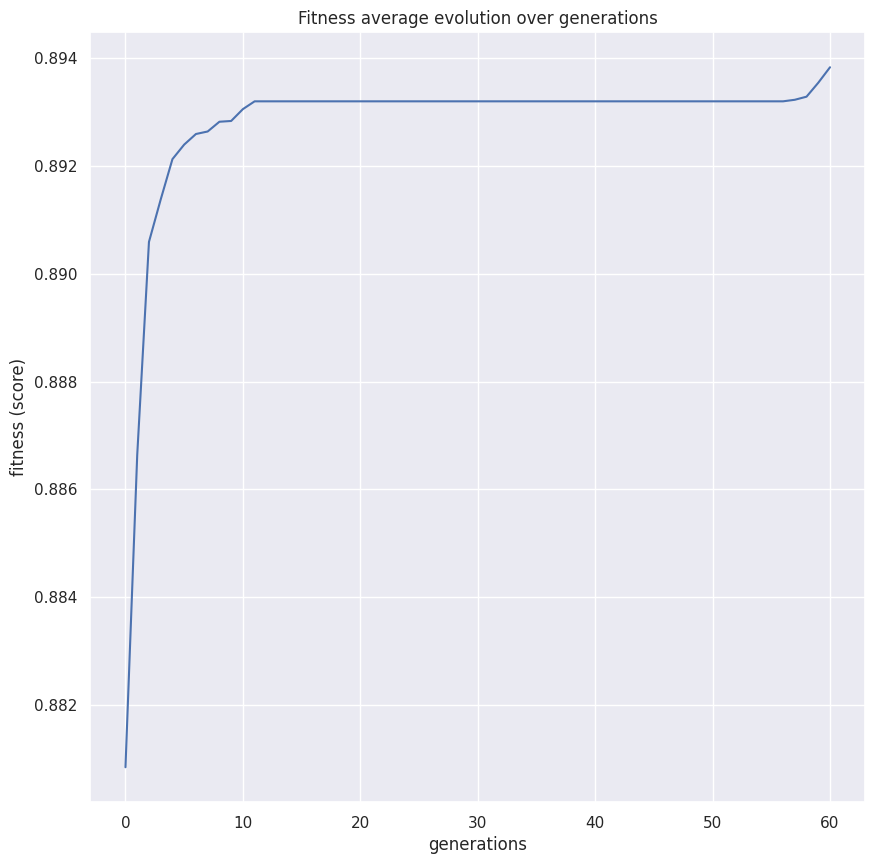

In [ ]:
plot = plot_fitness_evolution(evolved_estimator, metric="fitness")
plt.show()

## RandomForest optimization

Com este regressor eu farei diferente. Farei o AG selecionar as melhores características

In [ ]:
fs_estimator = GAFeatureSelectionCV(estimator=m_rf,
                                    cv=cv,
                                    scoring="r2",
                                    population_size=30,
                                    generations=60,
                                    elitism=True,
                                    keep_top_k=3,
                                    criteria="max",
                                    algorithm="eaMuPlusLambda",
                                    n_jobs=-1)

In [ ]:
fs_estimator.fit(_X, _y)
y_predict_ga = fs_estimator.predict(_X_pred)
r2 = r2_score(vazao_pred_gb['observed'].values, y_predict_ga)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	30    	0.858971	0.0663644  	0.932111   	0.723158   
1  	60    	0.904806	0.0285721  	0.937412   	0.799774   
2  	60    	0.903294	0.0332518  	0.92804    	0.785681   
3  	60    	0.902624	0.036886   	0.931245   	0.760511   
4  	60    	0.908653	0.0223489  	0.931245   	0.818778   
5  	60    	0.904744	0.027019   	0.931245   	0.805763   
6  	60    	0.913273	0.0220026  	0.931245   	0.805763   
7  	60    	0.909837	0.0275475  	0.935341   	0.825856   
8  	60    	0.919593	0.0183335  	0.935341   	0.827921   
9  	60    	0.917482	0.0242019  	0.935341   	0.830043   
10 	60    	0.909891	0.0389214  	0.935341   	0.783096   
11 	60    	0.92107 	0.0201705  	0.935341   	0.823996   
12 	60    	0.915403	0.0338171  	0.935341   	0.796495   
13 	60    	0.902597	0.0431185  	0.935341   	0.796495   
14 	60    	0.930005	0.00726445 	0.936766   	0.908013   
15 	60    	0.919366	0.0354904  	0.937029   	0.791625   
16 	60    	0.920793	0.027955   	0.937029   	0.80

In [ ]:
print(fs_estimator.get_params)
print("r2: ", "{:.2f}".format(r2))

In [ ]:
plot = plot_fitness_evolution(fs_estimator, metric="fitness")
plt.show()